#### Examples_Spike.ipynb

In this notebook, we set up central black hole, surrounded by a DM spike. We then evolve it forward to check for long term stability.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

from NbodyIMRI import tools, particles, simulator, reader
from NbodyIMRI import units as u
from NbodyIMRI import distributionfunctions as DF
import NbodyIMRI

#### Setting up the system parameters


In [3]:
M_1 = 1e6*u.Msun
M_2 = 1*u.Msun

rho_6 = 1e16*u.Msun/u.pc**3 #Normalisation of the spike
gamma_sp = 7/3

N_DM = 1000

Here, we're initialising a DM spike with density profile:

$$ \rho(r) = \rho_6 (r/r_6)^{-\gamma_\mathrm{sp}}$$

with $r_6 = 10^{-6}\,\mathrm{pc}$. The power-law spike is formally infinite, so we have to truncate at some radius $r_\mathrm{max}$. 

#### Generating initial conditions

Here, we generate a single BH surrounded by a DM spike with a power-law profile:



> Particle set:
>     M_1 [M_sun] = 1000000.0
 
>     N_DM = 1000
>     M_DM [M_sun] = 0.08749188828397382


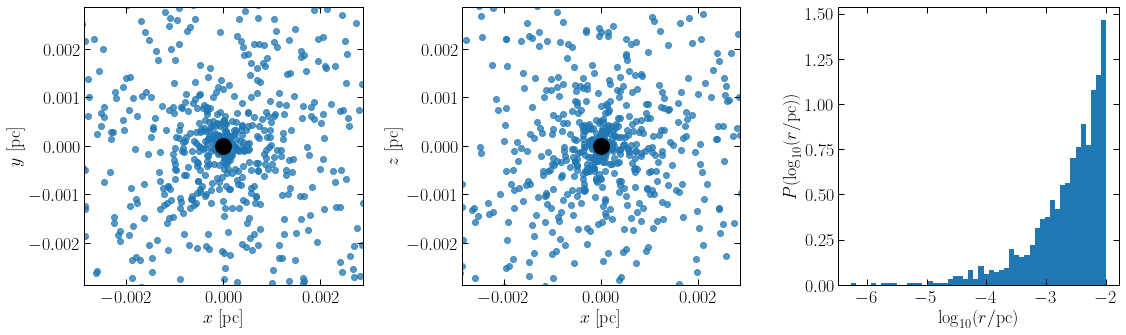

In [4]:
p_BH = particles.single_BH(M_1, N_DM = N_DM, rho_6 = rho_6, gamma_sp = gamma_sp, r_max = 1e-2*u.pc)

p_BH.summary()
p_BH.plot()

#### Setting up the simulator and simulation parameters

In [5]:
#Set the softening length
eps = 1e-8*u.pc

#Initialise the simulator object by passing the particle set with the initial conditions
sim = simulator.simulator(p_BH, r_soft_sq = eps**2)

#Let's estimate the orbital period at a distance of 1e-3 pc, to give us a sense of the timescales:
T_orb = tools.calc_Torb(1e-3*u.pc, M_1)

#Now let's evolve so that a typical particle at this radius orbits ~10 times
N_step_per_orb = 1000
N_orb = 10

t_end = T_orb*N_orb
dt    = T_orb/N_step_per_orb

sim.run_simulation(dt, t_end, show_progress=True)

  2%|▏         | 210/10000 [00:00<00:04, 2096.22it/s]

> Simulating...


100%|██████████| 10000/10000 [00:04<00:00, 2372.33it/s]

> Simulation completed.


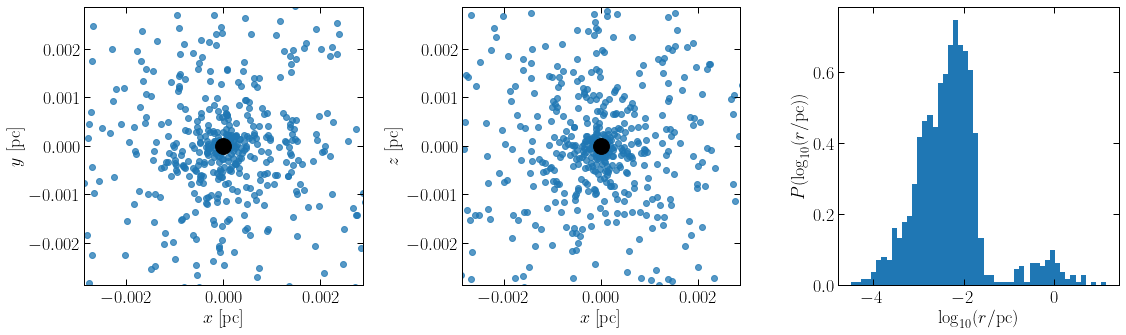

In [6]:
sim.p.plot()

This isn't too bad. But there's now a population of DM particles which are escaping to large radii! This is in part because we truncated our power-law spike, meaning that we didn't really have an equilibrium distribution in the first place. 

We can remedy this by using a *smoothly truncated* power-law density profile:

$$ \rho(r) = \rho_6 (r/r_6)^{-\gamma_\mathrm{sp}} (1 + r/r_t)^{-\alpha}$$

The truncation radius $r_t$ controls where the truncation kicks in. And the parameter $\alpha$ controls how quickly the density profile drops off. 

> Particle set:
>     M_1 [M_sun] = 1000000.0
 
>     N_DM = 1000
>     M_DM [M_sun] = 0.07043692096302556


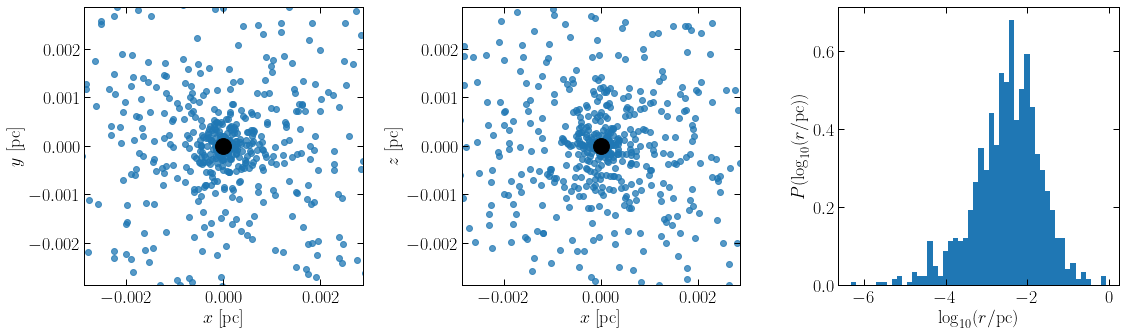

In [7]:
p_trunc = particles.single_BH(M_1, N_DM = N_DM, rho_6 = rho_6, gamma_sp = gamma_sp, r_max = 1*u.pc, r_t = 1e-2*u.pc, alpha=2)

p_trunc.summary()
p_trunc.plot()

Now let's simulate again:

In [8]:
#Note that the simulator object remembers the state of the particle set stored in internal memory, 
#so we want to reinstantiate every time we want to restart the simulation from the beginning.
sim_trunc = simulator.simulator(p_trunc, r_soft_sq = eps**2)
sim_trunc.run_simulation(dt, t_end, show_progress=True)

  3%|▎         | 251/10000 [00:00<00:03, 2502.27it/s]

> Simulating...


100%|██████████| 10000/10000 [00:03<00:00, 2577.63it/s]

> Simulation completed.


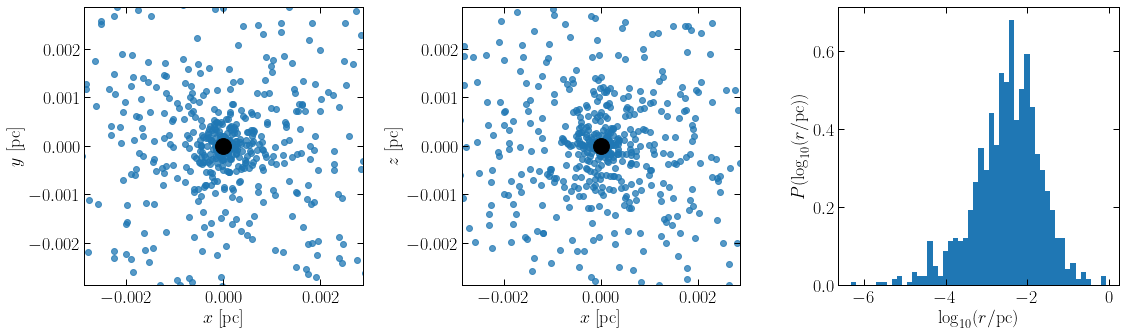

In [9]:
p_trunc.plot()

Much better!